# `Setup`

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
import random 
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset

# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math

# @title #### Import dependencies
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import os

import torch
from torch import nn
from torch.nn import functional as F
import torchvision


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/alexanderries/aml_itu
MPS device found.


In [46]:
# setting random number seed. Arbitrary seed is OK.
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### `Config`

In [47]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))

# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `Finetuned Models`

In [48]:
# IMG Transformations
transforms = {
    'train': v2.Compose([
    v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val': v2.Compose([
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.ToDtype(torch.float32, scale=True)])}



# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [49]:
# Normal Dataset
# Creating the dataset
train_data = StateFarmDataset(config,
                              transform=transforms['train'],
                              split='train',
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config,
                            transform=transforms['val'],
                            split='val',
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config,
                            split='test',
                            transform=transforms['val'],
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

Lenght of train data: 14409
Lenght of val data: 3345
Lenght of val data: 4670


#### `Model`

ResNet finetuning inspired by: https://colab.research.google.com/drive/1_pec9VGuU8PIxbYNh7Ed3xvFFFa5o1O1

In [50]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.fc = nn.Sequential(
            nn.BatchNorm1d(pretrained_net.fc.in_features, 512),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=10)
)

pretrained_net.train()

/Users/alexanderries/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alexanderries/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
# setting of loss function
#criterion = nn.CrossEntropyLoss()

# Freeze all layers except the fully connected layer
#for name, param in pretrained_net.named_parameters():
#    if 'fc' not in name:
#        param.requires_grad = False

fc_params = set(list(pretrained_net.fc.parameters()))
params_1x = [param for name, param in pretrained_net.named_parameters() if param not in fc_params]
        


In [52]:
def visualize_training(history, num_epochs=50):

    # Detach tensors and move to CPU if necessary, then convert to NumPy arrays
    train_loss = [tl.detach().cpu().numpy() if torch.is_tensor(tl) else tl for tl in history['train_loss']]
    val_loss = [vl.detach().cpu().numpy() if torch.is_tensor(vl) else vl for vl in history['val_loss']]
    train_acc = [ta.detach().cpu().numpy() if torch.is_tensor(ta) else ta for ta in history['train_acc']]
    val_acc = [va.detach().cpu().numpy() if torch.is_tensor(va) else va for va in history['val_acc']]

    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=train_loss, x=list(range(len(train_loss))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=val_loss, x=list(range(len(val_loss))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=train_acc, x=list(range(len(train_acc))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=val_acc, x=list(range(len(val_acc))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [53]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [54]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss mean and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [55]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [56]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [57]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping, model_name):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data + time for start of validation step
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        if scheduler != None:
            scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, model_name, epoch)
            visualize_training(history, epoch+1)
            break
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history


Epoch 1 of 50 started...
Epoch 1 of 50 (5:37) - Train loss: 2.28021 - Train acc: 0.15667 - Val loss: 2.25683 - Val acc: 0.11511
Saving model with new best val_loss: 2.25683

Epoch 2 of 50 started...
Epoch 2 of 50 (5:33) - Train loss: 2.16263 - Train acc: 0.37471 - Val loss: 2.04160 - Val acc: 0.39042
Saving model with new best val_loss: 2.04160

Epoch 3 of 50 started...
Epoch 3 of 50 (5:31) - Train loss: 1.76596 - Train acc: 0.59527 - Val loss: 1.54062 - Val acc: 0.71238
Saving model with new best val_loss: 1.54062

Epoch 4 of 50 started...
Epoch 4 of 50 (5:26) - Train loss: 1.22576 - Train acc: 0.75182 - Val loss: 1.06310 - Val acc: 0.82328
Saving model with new best val_loss: 1.06310

Epoch 5 of 50 started...
Epoch 5 of 50 (5:26) - Train loss: 0.80339 - Train acc: 0.84628 - Val loss: 0.82512 - Val acc: 0.85163
Saving model with new best val_loss: 0.82512


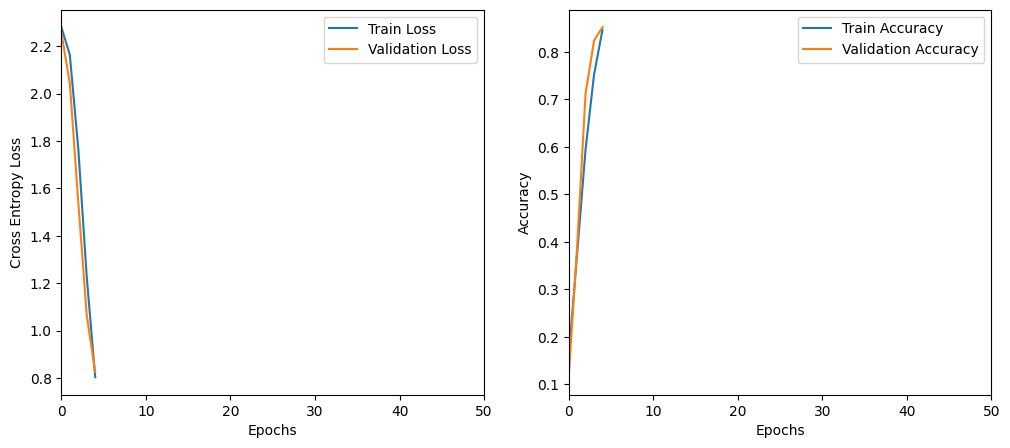


Epoch 6 of 50 started...
Epoch 6 of 50 (5:36) - Train loss: 0.55777 - Train acc: 0.90282 - Val loss: 0.66474 - Val acc: 0.88340
Saving model with new best val_loss: 0.66474

Epoch 7 of 50 started...
Epoch 7 of 50 (5:32) - Train loss: 0.41219 - Train acc: 0.93888 - Val loss: 0.54591 - Val acc: 0.89828
Saving model with new best val_loss: 0.54591

Epoch 8 of 50 started...
Epoch 8 of 50 (5:29) - Train loss: 0.31216 - Train acc: 0.95995 - Val loss: 0.47708 - Val acc: 0.90245
Saving model with new best val_loss: 0.47708

Epoch 9 of 50 started...
Epoch 9 of 50 (5:28) - Train loss: 0.24831 - Train acc: 0.97218 - Val loss: 0.45202 - Val acc: 0.90893
Saving model with new best val_loss: 0.45202

Epoch 10 of 50 started...
Epoch 10 of 50 (5:27) - Train loss: 0.20838 - Train acc: 0.97769 - Val loss: 0.41408 - Val acc: 0.92150
Saving model with new best val_loss: 0.41408


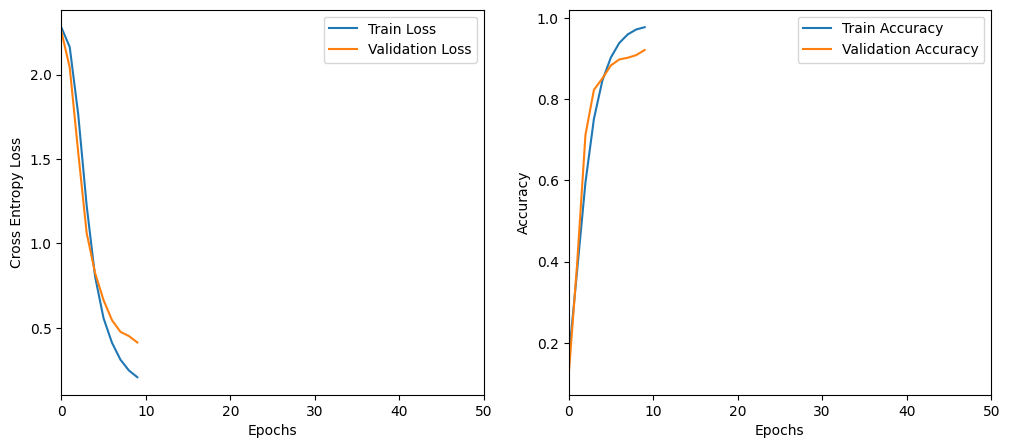


Epoch 11 of 50 started...
Epoch 11 of 50 (5:26) - Train loss: 0.17579 - Train acc: 0.98361 - Val loss: 0.44851 - Val acc: 0.89329
Early Stopping Counter 1 of 5

Epoch 12 of 50 started...
Epoch 12 of 50 (5:23) - Train loss: 0.15543 - Train acc: 0.98621 - Val loss: 0.41819 - Val acc: 0.90305

Epoch 13 of 50 started...
Epoch 13 of 50 (5:26) - Train loss: 0.13821 - Train acc: 0.99030 - Val loss: 0.38255 - Val acc: 0.90755
Saving model with new best val_loss: 0.38255
Early Stopping Counter Reset

Epoch 14 of 50 started...
Epoch 14 of 50 (5:29) - Train loss: 0.13348 - Train acc: 0.98991 - Val loss: 0.37431 - Val acc: 0.90777
Saving model with new best val_loss: 0.37431

Epoch 15 of 50 started...
Epoch 15 of 50 (5:26) - Train loss: 0.12608 - Train acc: 0.99037 - Val loss: 0.42801 - Val acc: 0.88069


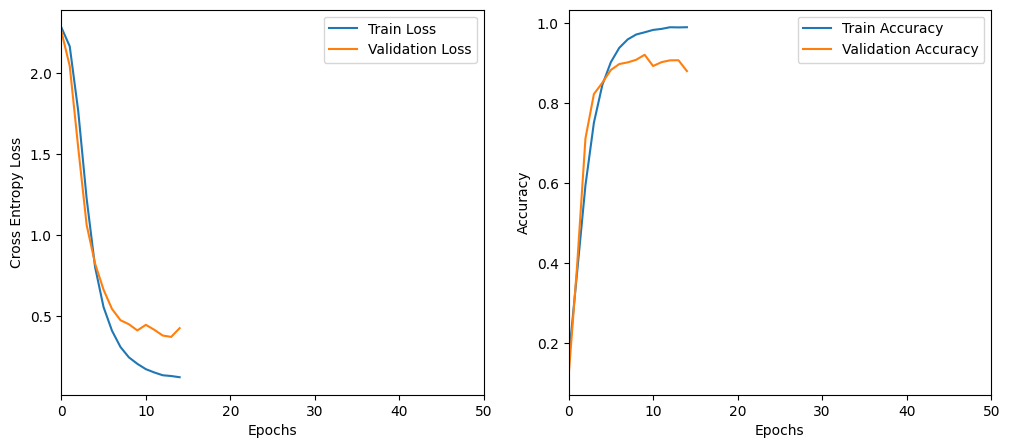

Early Stopping Counter 1 of 5

Epoch 16 of 50 started...
Epoch 16 of 50 (5:26) - Train loss: 0.11845 - Train acc: 0.99158 - Val loss: 0.43380 - Val acc: 0.87626
Early Stopping Counter 2 of 5

Epoch 17 of 50 started...
Epoch 17 of 50 (5:23) - Train loss: 0.11178 - Train acc: 0.99289 - Val loss: 0.43416 - Val acc: 0.87857
Early Stopping Counter 3 of 5

Epoch 18 of 50 started...
Epoch 00018: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00018: reducing learning rate of group 1 to 1.0000e-03.
Epoch 18 of 50 (5:27) - Train loss: 0.10723 - Train acc: 0.99376 - Val loss: 0.39424 - Val acc: 0.89541
Early Stopping Counter 4 of 5

Epoch 19 of 50 started...
Epoch 19 of 50 (5:26) - Train loss: 0.10381 - Train acc: 0.99397 - Val loss: 0.41351 - Val acc: 0.89471
Early Stopping Counter 5 of 5
Epoch 19 of 50 - Early stopping
Saving final model, with loss:  0.4135069885424205


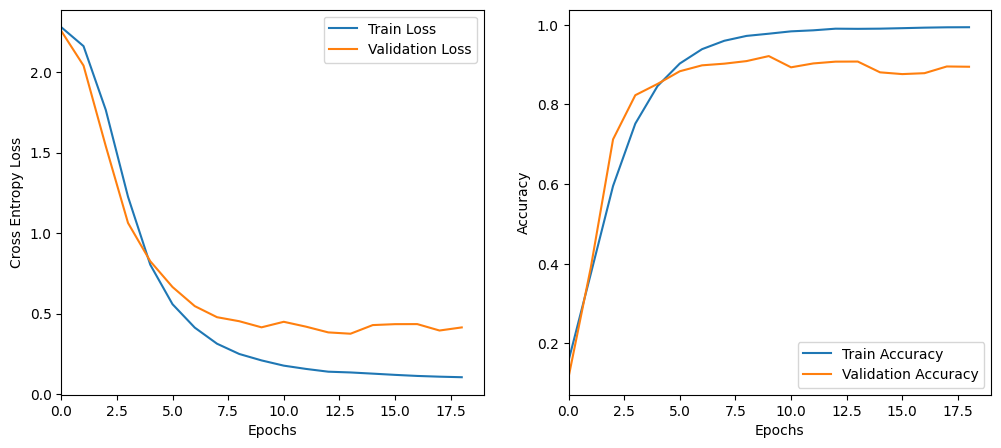

Total training time: 103:59


In [58]:
# Set device
MODEL_NAME = 'ResNet_v2'
model = pretrained_net.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.CrossEntropyLoss(reduction='none')

# Isolate the parameters of the fc layer
#fc_params = pretrained_net.fc.parameters()

# Create the optimizer
#optimizer = torch.optim.SGD(fc_params, lr=1e-3, momentum=0.9, weight_decay=0.01)

learning_rate = 1e-3
#learning_rate = 5e-5

optimizer = torch.optim.SGD([
            {'params': params_1x},
            {'params': pretrained_net.fc.parameters(), 'lr': learning_rate * 10}
        ], lr=learning_rate, momentum=0.9, weight_decay=0.001)

# scheduler + early stopping
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min',
                                                       factor=.1,
                                                       patience=3,
                                                       min_lr=1e-7,
                                                       verbose=True)

early_stopping = EarlyStopper(patience=5, min_delta=.01)

batch_size = config['modeling_params']['batch_size']
epochs = 50 

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# results
results = train(model=model,
                train_dataloader=train_dataloader,
                validation_dataloader=val_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                scheduler=scheduler,
                early_stopping=early_stopping,
                model_name=MODEL_NAME)

### Test

In [65]:
# Model Setup
model_name = 'ResNet_v2'
model = pretrained_net

# Load the saved model weights
model_load_path = 'outputs/ResNet_v2/ResNet_v2_20240103_011814_epoch_10.pt' # model with lowest val loss
#model_load_path = 'outputs/ResNet_v2/ResNet_v2_20231230_141249_epoch_5.pt' # model with lowest val loss and closest train/val loss

model.load_state_dict(torch.load(model_load_path, map_location=torch.device('mps')))
model = model.to(device)

In [66]:
def test(model, dataloader, device):
    """Test loop"""
    model.eval()
    # Setup test accuracy
    test_acc = 0
    
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)
            
            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Accuracy {test_acc / len(dataloader)}')
    return images, classes, predictions, predictions_argmax

In [67]:
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

t = test(pretrained_net, test_dataloader, device)

Test Accuracy 0.8616988748720248
